<a href="https://colab.research.google.com/github/Gabril0/CNN/blob/main/Attention_UNET_Oral_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Summary of the model studied
The model studied focus mainly in providing an U-NET with a good and robust data augmentation to avoid pitfalls and enhance the learning capabilities.

In [1]:
#downloading the dataset
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/9bsc36jyrt-1.zip

--2024-03-06 13:36:04--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/9bsc36jyrt-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.92.2.226, 3.5.65.1, 52.92.19.98, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.92.2.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1081025712 (1.0G) [application/zip]
Saving to: ‘9bsc36jyrt-1.zip’

9bsc36jyrt-1.zip    100%[===================>]   1.01G  11.8MB/s    in 90s     

2024-03-06 13:37:35 (11.5 MB/s) - ‘9bsc36jyrt-1.zip’ saved [1081025712/1081025712]



In [2]:
#imports
import os
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random


In [3]:
#unzipping
!unzip /content/9bsc36jyrt-1.zip
!rm -r "/content/9bsc36jyrt-1.zip"
clear_output()

In [4]:
#getting path references
#training used only the roi folders

testing_folder1 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/testing/tumor/patch/640x640/1009009/01-roi"
testing_folder2 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/testing/tumor/patch/640x640/1009010x1000902/01-roi"
testing_folder3 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/testing/tumor/patch/640x640/1009011/01-roi"
testing_folder4 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/testing/tumor/patch/640x640/1009014/01-roi"
testing_folder5 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/testing/tumor/patch/640x640/1009016x1000903/01-roi"
testing_folder6 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/testing/tumor/patch/640x640/1009023/01-roi"

training_folder1 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/training/tumor/patch/640x640/1009009/01-roi"
training_folder2 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/training/tumor/patch/640x640/1009010x1000902/01-roi"
training_folder3 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/training/tumor/patch/640x640/1009011/01-roi"
training_folder4 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/training/tumor/patch/640x640/1009014/01-roi"
training_folder5 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/training/tumor/patch/640x640/1009016x1000903/01-roi"
training_folder6 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/training/tumor/patch/640x640/1009023/01-roi"

training_folders = [training_folder1, training_folder2, training_folder3, training_folder4, training_folder5, training_folder6]
#the mask folders will be added dinamically
testing_folders = [testing_folder1, testing_folder2, testing_folder3, testing_folder4, testing_folder5, testing_folder6]

training_path = []
mask_path = []
test_path = []
test_mask_path = []


def append_paths(folder, pathList, complementaryPath):
    full_path = os.path.join(folder, complementaryPath)
    if os.path.isdir(full_path):
        for file in os.listdir(full_path):
            if file.endswith(".png"):
                pathList.append(os.path.join(full_path, file))
            else:
                print("error in file " + file)
    else:
        print("error: " + full_path + " could not be found")

for folder in training_folders: #appending the paths for the original images and respective masks
  append_paths(folder,training_path,"01-original")
  append_paths(folder,mask_path,"02-mask")

for folder in testing_folders: #appending the paths for the test images
  append_paths(folder,test_path,"01-original")
  append_paths(folder,test_mask_path,"02-mask")


In [5]:
#transforming into numpy array

def path_to_array(path, numpyArray):
  for file in path:
    image = plt.imread(file)
    image_array = np.array(image)
    resized_image = cv2.resize(image_array, (120,120))
    numpyArray.append(resized_image)

training_array = []
mask_array = []
test_array = []
test_mask_array = []

path_to_array(training_path, training_array)
path_to_array(mask_path, mask_array)
path_to_array(test_path, test_array)
path_to_array(test_mask_path, test_mask_array)


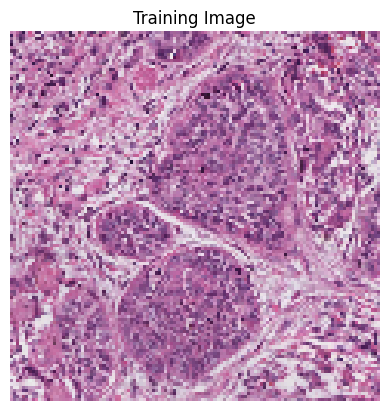

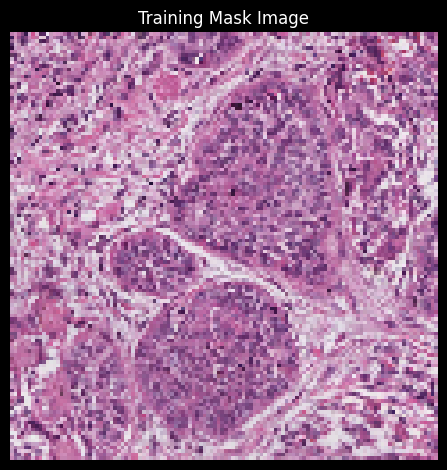

In [15]:
#showing an image
plt.imshow(training_array[10000])
plt.title('Training Image')
plt.axis('off')

plt.figure(facecolor='black')
plt.imshow(mask_array[10000])
plt.title('Training Mask Image',color="white")
plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
print(len(training_array))

30512716


In [7]:
#data augmentation
#do data augmentation horizontal flip, vertical flip, rotation, transpose, grid distortion,
#optical distortion, color transfer, inpainting
def flip_horizontal(image_array,mask_array):
  for image, mask in zip(training_array, mask_array):
    aug_image = np.flip(image, axis=1)
    aug_mask = np.flip(image, axis=1)

    image_array.append(aug_image)
    mask_array.append(aug_mask)


def flip_vertical(image_array,mask_array):
  for image, mask in zip(training_array, mask_array):
    aug_image = np.flip(image, axis=0)
    aug_mask = np.flip(image, axis=0)

    image_array.append(aug_image)
    mask_array.append(aug_mask)


def random_rotation(image_array,mask_array):
  for image, mask in zip(training_array, mask_array):
    angle = random.uniform(0, 360)

    height, width = image.shape[:2]

    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)

    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    rotated_mask = cv2.warpAffine(mask, rotation_matrix, (width, height))

    image_array.append(rotated_image)
    mask_array.append(rotated_mask)



def grid_distort(image_array,mask_array, rows=10, cols=10):
  for image, mask in zip(training_array, mask_array):
    distort_grid = np.indices(image.shape[:2], dtype=np.float32)
    distort_grid += np.random.normal(size=distort_grid.shape) * 10

    distort_grid[0] = np.clip(distort_grid[0], 0, image.shape[0] - 1)
    distort_grid[1] = np.clip(distort_grid[1], 0, image.shape[1] - 1)

    map_x = distort_grid[1]
    map_y = distort_grid[0]

    distorted_image = cv2.remap(image, map_x, map_y, cv2.INTER_LINEAR)
    distorted_mask = cv2.remap(mask, map_x, map_y, cv2.INTER_LINEAR)

    image_array.append(distorted_image)
    mask_array.append(distorted_mask)


flip_horizontal(training_array,mask_array)
flip_vertical(training_array,mask_array)
random_rotation(training_array,mask_array)
grid_distort(training_array,mask_array)


KeyboardInterrupt: 

In [ ]:
#do accuracy, precision, F1, IOU, Sensitivity, Specificity